In [5]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
import os
import requests, tarfile
CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)

/content


In [7]:
CIFAR_DIR = os.path.join(CURRENT_DIR, 'data','cifar')
print(CIFAR_DIR)
def download_CIFAR(path=CIFAR_DIR, url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', redownload=False):
    if os.path.exists(path) and redownload is False:
        print('Dataset already exists')
        return
    print('Downloading...')
    r = requests.get(url, stream=True)
    # show download progress
    total_length = r.headers.get('content-length')
    with open('cifar-10-python.tar.gz', 'wb') as f:
        if total_length is None: # no content length header
            f.write(r.content)
        else:
            dl = 0
            total_length = int(total_length)
            for chunk in r.iter_content(chunk_size=1024):
                dl += len(chunk)
                f.write(chunk)
                done = int(50 * dl / total_length)
                print('\r[{}{}]'.format('=' * done, ' ' * (50-done)), end='')
    print('Extracting...')
    with tarfile.open('cifar-10-python.tar.gz') as f:
        f.extractall(path)
    print('Done!')

download_CIFAR()

/content/data/cifar
Dataset already exists


In [8]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

# load meta data
meta = unpickle(os.path.join(CIFAR_DIR, 'cifar-10-batches-py', 'batches.meta'))
print(meta['label_names'])

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# load all train data and combine all data them into one
import numpy as np
cifar_train_files = ['data_batch_{}'.format(i) for i in range(1,6)]
print(cifar_train_files)
cifar_train_data = [unpickle(os.path.join(CIFAR_DIR, 'cifar-10-batches-py', f)) for f in cifar_train_files]

cifar_train_imgs = np.vstack([d['data'] for d in cifar_train_data])
cifar_train_labels = np.hstack([d['labels'] for d in cifar_train_data])

print(cifar_train_imgs.shape, cifar_train_labels.shape)

['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
(50000, 3072) (50000,)


In [10]:
# load all test data
cifar_test_data = unpickle(os.path.join(CIFAR_DIR, 'cifar-10-batches-py', 'test_batch'))
cifar_test_imgs = cifar_test_data['data']
cifar_test_labels = np.array(cifar_test_data['labels'])

In [11]:
# reshape the images
cifar_train_imgs = cifar_train_imgs.reshape((50000, 3, 32, 32))
cifar_train_imgs = np.rollaxis(cifar_train_imgs, 1, 4)
cifar_train_labels = cifar_train_labels.reshape((50000, 1))

cifar_test_imgs = cifar_test_imgs.reshape((10000, 3, 32, 32))
cifar_test_imgs = np.rollaxis(cifar_test_imgs, 1, 4)
cifar_test_labels = cifar_test_labels.reshape((10000, 1))


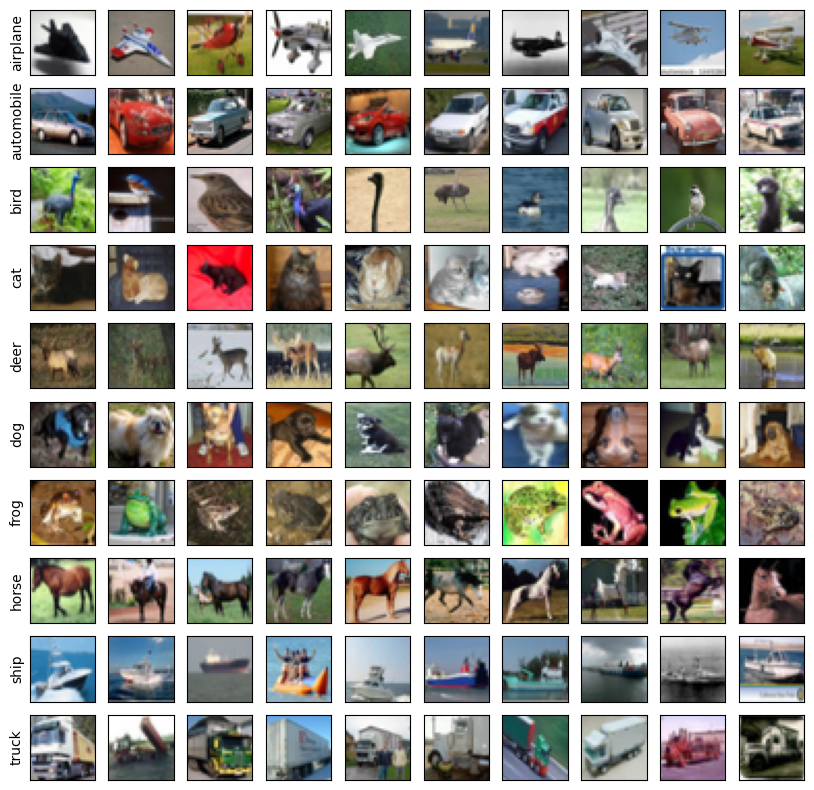

In [12]:
# show 5 images of each label and their names
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    idx = np.where(cifar_train_labels == i)[0]
    for j in range(10):
        axes[i][j].imshow(cifar_train_imgs[idx[j]])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    axes[i][0].set_ylabel(meta['label_names'][i])

In [13]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


fasgion_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

fasgion_test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

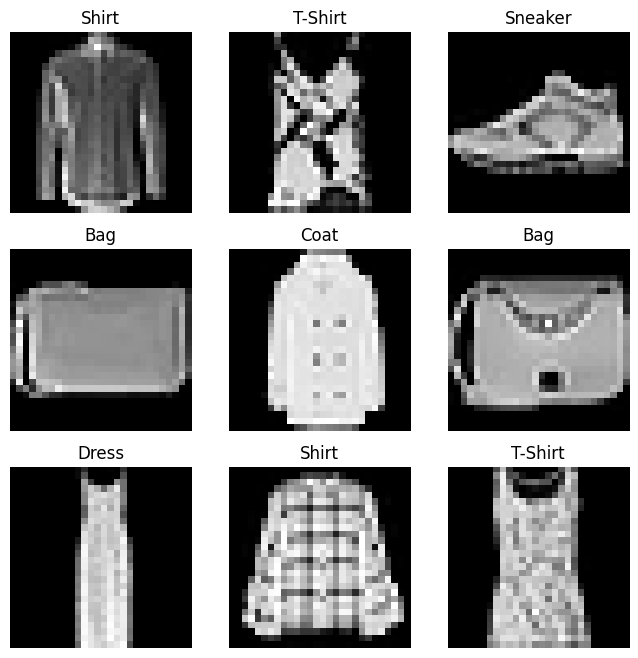

In [14]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fasgion_training_data), size=(1,)).item()
    img, label = fasgion_training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms

In [49]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):

        super(Net, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x


net = Net()
net.cuda()

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [29]:
running_losses=[]
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs=inputs.cuda()
        labels=labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('Epoch: {}\t Training Loss: {}'.format(epoch,running_loss/i))
    running_losses.append(running_loss/i)

print('Finished Training')

Epoch: 0	 Training Loss: 1.4406438122848932
Epoch: 1	 Training Loss: 0.8913168416780775
Epoch: 2	 Training Loss: 0.6901427640312431
Epoch: 3	 Training Loss: 0.5640912150540033
Epoch: 4	 Training Loss: 0.46954852004213876
Epoch: 5	 Training Loss: 0.3913766879177674
Epoch: 6	 Training Loss: 0.32356717052156564
Epoch: 7	 Training Loss: 0.265906005470949
Epoch: 8	 Training Loss: 0.21388432249894926
Epoch: 9	 Training Loss: 0.173935490494714
Epoch: 10	 Training Loss: 0.1396498104895414
Epoch: 11	 Training Loss: 0.10931257703130981
Epoch: 12	 Training Loss: 0.09321039625809767
Epoch: 13	 Training Loss: 0.078288338983836
Epoch: 14	 Training Loss: 0.06924786207486684
Epoch: 15	 Training Loss: 0.0567948905270564
Epoch: 16	 Training Loss: 0.048618798684565326
Epoch: 17	 Training Loss: 0.0414339584606264
Epoch: 18	 Training Loss: 0.03847411936716986
Epoch: 19	 Training Loss: 0.03751910283059768
Epoch: 20	 Training Loss: 0.03257397719409485
Epoch: 21	 Training Loss: 0.03291979729837243
Epoch: 22	 

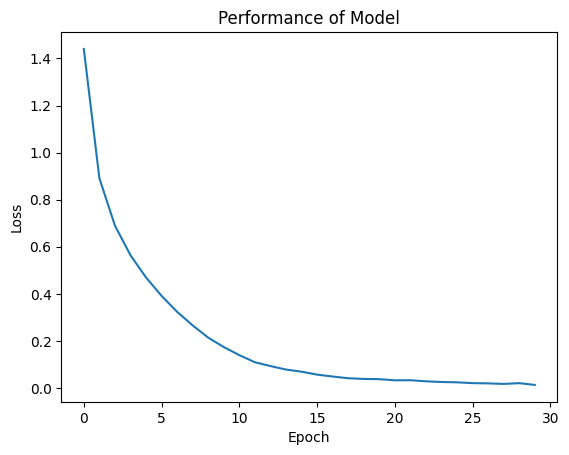

In [30]:
plt.plot(range(30), running_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model")
plt.show()

In [31]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data, target in testloader:
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(np.squeeze(correct_tensor.cpu().numpy()))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.867332

Test Accuracy of airplane: 84% (846/1000)
Test Accuracy of automobile: 93% (932/1000)
Test Accuracy of  bird: 75% (750/1000)
Test Accuracy of   cat: 67% (677/1000)
Test Accuracy of  deer: 85% (856/1000)
Test Accuracy of   dog: 75% (757/1000)
Test Accuracy of  frog: 91% (913/1000)
Test Accuracy of horse: 84% (849/1000)
Test Accuracy of  ship: 88% (889/1000)
Test Accuracy of truck: 90% (908/1000)

Test Accuracy (Overall): 83% (8377/10000)


In [33]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [50]:
def training(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.9, weight_decay=5e-4)
    running_losses=[]
    for epoch in range(200):  # loop over the dataset multiple times

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs=inputs.cuda()
            labels=labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('Epoch: {}\t Training Loss: {}'.format(epoch,running_loss/i))
        running_losses.append(running_loss/i)
    plt.plot(range(200), running_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Performance of Model")
    plt.show()
    print('Finished Training')

In [41]:
def test(model):
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck']
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(np.squeeze(correct_tensor.cpu().numpy()))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(testloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [ ]:
resnet18=ResNet18().to(device)
training(resnet18)

Epoch: 0	 Training Loss: 2.3799805017618034
Epoch: 1	 Training Loss: 2.380312811411344
Epoch: 2	 Training Loss: 2.3803185988695192
Epoch: 3	 Training Loss: 2.380086214114458
Epoch: 4	 Training Loss: 2.379897350531358
Epoch: 5	 Training Loss: 2.3800136951299815
Epoch: 6	 Training Loss: 2.3800826897987952
Epoch: 7	 Training Loss: 2.379924638454731
Epoch: 8	 Training Loss: 2.379965290045127
Epoch: 9	 Training Loss: 2.38019705980252
Epoch: 10	 Training Loss: 2.3805230678656164
Epoch: 11	 Training Loss: 2.380215109922947
Epoch: 12	 Training Loss: 2.3801414942130066
Epoch: 13	 Training Loss: 2.3799493251702724
Epoch: 14	 Training Loss: 2.380096220358824
Epoch: 15	 Training Loss: 2.379602259856004
Epoch: 16	 Training Loss: 2.3800557411634005
Epoch: 17	 Training Loss: 2.380008461536505
